In [1]:
# Code based off the following tutorial: 
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

# Introduction

This is a minimum viable implementation of a learning-based clock bias prediction model. Ideally this model would run locally in a system with limited GPS accessiblity. We have historical IGS data available. 

Currently in progress is trying the model with many ephemeris features vs just SV name, and past clock bias values reported by IGS. This model is beneficial because IGS normally may take ~17 days to push out very exact clock bias predictions. 

The objective is to take in a sequence of the features (i.e. from the previous 20 days to predict the target variable (Final Clock Bias in seconds) for 20 days in the future).

# Data Preprocessing

This data is readily available from CDDIS and IGS in the form of RNX files for the satellite ephemeris data and CLK files for the final clock bias that has been processed by IGS and produced after ~17 days. 

Now, the original tutorial is based off financial data, and this has been completed in a different file.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np 
import torch 
import torch.nn as nn
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
historical_window = 5 # [minutes]
forward_window = 100 # [minutes]

In [4]:
filename = "5_resampled_1min_interval.csv"

In [5]:
df = pd.read_csv(filename, index_col = 'epoch', parse_dates=True)
df = df[["SV Name", "Clock Bias (seconds)", "File"]]
df.head(5)

,SV Name,Clock Bias (seconds),File
epoch,,,
2018-04-15 00:00:00,1,-0.000041,KITG00UZB_R_20181040000_01D_GN.rnx
2018-04-15 00:01:00,1,-0.000041,NaN
2018-04-15 00:02:00,1,-0.000041,NaN
2018-04-15 00:03:00,1,-0.000041,NaN
2018-04-15 00:04:00,1,-0.000041,NaN


In [6]:
df.describe()

,SV Name,Clock Bias (seconds)
count,308191.000000,308191.000000
mean,16.904595,-0.000005
std,9.100347,0.000343
min,1.000000,-0.000737
25%,9.000000,-0.000218
50%,17.000000,-0.000010
75%,25.000000,0.000205
max,32.000000,0.000708


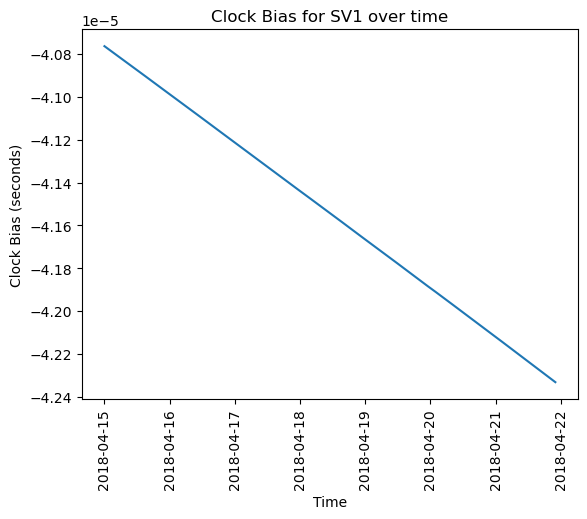

In [7]:
plt.plot(df[(df["SV Name"] == 1)]["Clock Bias (seconds)"])
plt.xlabel("Time")
plt.ylabel("Clock Bias (seconds)")
plt.xticks(rotation=90)
plt.title("Clock Bias for SV1 over time")
plt.savefig("sv1_clock_bias_plot.png", dpi = 250)
plt.show(); 

In [8]:
X, y = df.drop(columns=['File']), df['Clock Bias (seconds)'] # in this case, it would be useful to have col names without spaces 
X.shape, y.shape

((308191, 2), (308191,))

In [9]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
# y_trans = mm.fit_transform(y.reshape(-1,1)) # reshape has been deprecated https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape 
y_trans = mm.fit_transform(y.values.reshape(-1,1))

In [10]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break

        # gather input and output of the pattern 
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, historical_window, forward_window)
print(X_ss.shape, y_mm.shape)


(308088, 5, 2) (308088, 100)


In [11]:
def add_regression_noise(y, std=0.1): 
    noise = np.random.normal(0, std, size=y.shape)
    return y + noise

Let's check if the first sample in <code>y_mm</code> starts at the 100th sample in the original <code>y</code> vector

In [12]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [13]:
y_mm[0]

array([0.48182863, 0.48182852, 0.48182842, 0.48182831, 0.4818282 ,
       0.4818281 , 0.48182799, 0.48182788, 0.48182778, 0.48182767,
       0.48182756, 0.48182745, 0.48182735, 0.48182724, 0.48182713,
       0.48182703, 0.48182692, 0.48182681, 0.48182671, 0.4818266 ,
       0.48182649, 0.48182638, 0.48182628, 0.48182617, 0.48182606,
       0.48182596, 0.48182585, 0.48182574, 0.48182564, 0.48182553,
       0.48182542, 0.48182532, 0.48182521, 0.4818251 , 0.48182499,
       0.48182489, 0.48182478, 0.48182467, 0.48182457, 0.48182446,
       0.48182435, 0.48182425, 0.48182414, 0.48182403, 0.48182392,
       0.48182382, 0.48182371, 0.4818236 , 0.4818235 , 0.48182339,
       0.48182328, 0.48182318, 0.48182307, 0.48182296, 0.48182286,
       0.48182275, 0.48182264, 0.48182253, 0.48182243, 0.48182232,
       0.48182221, 0.48182211, 0.481822  , 0.48182189, 0.48182179,
       0.48182168, 0.48182157, 0.48182146, 0.48182136, 0.48182125,
       0.48182114, 0.48182104, 0.48182093, 0.48182082, 0.48182

In [14]:
y_trans[99:149].squeeze(1)

array([0.48181847, 0.48181836, 0.48181826, 0.48181815, 0.48181804,
       0.48181794, 0.48181783, 0.48181772, 0.48181761, 0.48181751,
       0.4818174 , 0.48181729, 0.48181719, 0.48181708, 0.48181697,
       0.48181687, 0.48181676, 0.48181665, 0.48181655, 0.48181644,
       0.48181633, 0.48181622, 0.48181612, 0.48181601, 0.4818159 ,
       0.48181579, 0.48181568, 0.48181558, 0.48181547, 0.48181536,
       0.48181525, 0.48181514, 0.48181503, 0.48181493, 0.48181482,
       0.48181471, 0.4818146 , 0.48181449, 0.48181439, 0.48181428,
       0.48181417, 0.48181406, 0.48181395, 0.48181384, 0.48181374,
       0.48181363, 0.48181352, 0.48181341, 0.4818133 , 0.4818132 ])

We want to predict the data several months into the future, therefore we can use a training data size of 95% with 5% left for the remaining data for prediction. This gives us a training set of 2763 day (or 7.5 years) and predicting 145 days into the future (5 months). 

In [15]:
total_samples = len(X)
train_test_cutoff = round(0.10 * total_samples)

In [16]:
X_train = X_ss[:-train_test_cutoff]
X_test = X_ss[-train_test_cutoff:]

In [17]:
y_train = y_mm[:-train_test_cutoff]
y_train = add_regression_noise(y_train)
y_test = y_mm[-train_test_cutoff:]

In [18]:
train_test_cutoff

30819

In [19]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (277269, 5, 2) (277269, 100)
Testing Shape: (30819, 5, 2) (30819, 100)


Now we convert our data into tensors by calling <code>torch.tensor()</code> on our object, and setting the property <code>requires_grad = True</code>. Some old PyTorch tutorials might indicate that we need to apply <code>Variable</code> on here but this is deprecated. Now the input tensor to be forward propagated has to be can faciliate automatic back propagation through <code> backward()</code> without being wrapped.

In [20]:
# convert to pytorch tensors 
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

Looking through the documentation for a multi-layer <code>torch.nn.LSTM</code> shows that the input shape depends on whether the parameter <code>batch_first</code> is true. Since we are accustomed to having the first dimension be the batch, we can set <code>batch_first</code> to true. The size of the input is then <code>(N, L, H_in)</code> where

- N is the batch size 
- L is the sequence length
- H_in is the input size (number of features)

In other words, we wantt eh dimensions to be the rows of the dataframe in the first dimension. Followed by the length of the dataframe in the next dimension to represent the length of the input sequence, and finally the feature of which we have 4 in the final dimension. 

To reshape the tensors into our required shape we can use <code>torch.reshape</code>. This takes as arguments the tensors we are reshaping, and then a tuple of the shape we need to reshape to. For the rows of the dataframe, we can simply look at the shape of the first dimension <code>X_train_tensors.shape[0]</code>. Since we are applying an LSTM, we call tha tthe sequence length we feed in is simply 1 because the whole point of the LSTM is not feeding in tons of data at each because the emory is handled by the inner working of the LSTM cell. 

The last dimension is the number of features which is stored in the <code>X_train_tensors.shape[1]</code>. 

In [21]:
# reshape to rows, timestamps, features 

X_train_tensors_final = torch.reshape(X_train_tensors, 
                                      (X_train_tensors.shape[0], historical_window, 
                                      X_train_tensors.shape[2]))

X_test_tensors_final = torch.reshape(X_test_tensors, 
                                     (X_test_tensors.shape[0], historical_window, 
                                      X_test_tensors.shape[2]))

print("Training shape:", X_train_tensors.shape, y_train_tensors.shape)
print("Testing shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training shape: torch.Size([277269, 5, 2]) torch.Size([277269, 100])
Testing shape: torch.Size([30819, 5, 2]) torch.Size([30819, 100])


Let's make sure that the data logic of the test set checks out. Sequential data is hard to get our heads around and especially when generating a test set for multistep output models. Here, we want to take the 100 previous predictors up to the current time step and predict 50 time steps into the future. In the test set, we have 150 batch feature samples, each consisting of 100 time steps and 4 feature predictors. 

In the targets for the test set, we again have 150 batch samples, each consisting of an array of length 50 of scalar outputs. 

Since we want a way to validate our results, we need to predict the Bitcoin price for 50 time steps in the test set for which we have the data (i.e. the test targets). Because of the way we wrote the <code> split_sequence()</code>, we just need the last sample of 100 days in <code>X_test</code>, run the model on it and compare those predictions with the last sample of the 50 days of <code>y_test</code>. These correspond to a period of 100 days in the <code>X_test</code>'s last sample, proceeded immediately by the next 50 days in the last sample of <code>y_test</code>. 

In [22]:
X_check, y_check = split_sequences(X, y.values.reshape(-1,1), historical_window, forward_window) # see above - just doing y.reshape is deprecated
X_check[-1][0:4]

array([[ 3.20000000e+01, -5.18315418e-04],
       [ 3.20000000e+01, -5.18315180e-04],
       [ 3.20000000e+01, -5.18314943e-04],
       [ 3.20000000e+01, -5.18314705e-04]])

In [23]:
X.iloc[-149:-145]

,SV Name,Clock Bias (seconds)
epoch,,
2018-04-21 19:32:00,32,-0.000518
2018-04-21 19:33:00,32,-0.000518
2018-04-21 19:34:00,32,-0.000518
2018-04-21 19:35:00,32,-0.000518


The first four rows of the data match. Note that <code>X_check[-1]</code> should be identical to the <code>X.iloc[-149:-49]</code>, ending 50 days before the end of our dataset. Therefore, we are taking the 100 timesteps of information up to the 26th of Nov 2021, and attempting to predict the 50 days after that up to 14th January 2022. Our final check is to make sure that the final batch sample in our test targets matches these data predictions. 

In [24]:
y_check[-1]

array([-0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.00051831, -0.00051831, -0.00051831, -0.00051831, -0.00051831,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.00

In [25]:
df["Clock Bias (seconds)"].values[-50:]

array([-0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 , -0.0005183 ,
       -0.0005183 , -0.0005183 , -0.0005183 , -0.00051829, -0.00051829,
       -0.00051829, -0.00051829, -0.00051829, -0.00051829, -0.00051829,
       -0.00051829, -0.00051829, -0.00051829, -0.00051829, -0.00051829,
       -0.00051829, -0.00051829, -0.00051829, -0.00051829, -0.00051829])

Summary: The main performance test for our model will be on the last batch sample in the test set. This will be predictors rom the 100 time steps up to the 26th of Nov 2021 and this will be used by our model to predict the next 50 days of Bitcoin prices up to the 14th of Jan 2022. In this way, we validate model performance by comparing predcitions to the actual prices in that 50 day window. 

# Constructing the LSTM model

Now, let's construct the LSTM class, inheriting from the nn.Module. In constract to the previous univariate LSTM, we're going to build the model with the nn.LSTM rather than nn.LSTMCell because it's good to understand both options and we dont really need the nn.LSTMCell flexibility right now. We know that nn.LSTM is a recurrent application of the nn.LSTMCell. 

In [26]:
class LSTM(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers): 
        super().__init__()
        self.num_classes = num_classes # output size 
        self.num_layers = num_layers # number of recurrent layers in the LSTM 
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm later

        # LSTM model 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 128) # fully connected 
        self.fc2 = nn.Linear(128, num_classes) # last FC
        self.relu = nn.ReLU()

    def forward(self, x): 
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propgagate input through LSTM
        output, (hn, cn) =self.lstm(x, (h_0, c_0)) # (input, hidden and internal state)
        hn = hn.view(-1, self.hidden_size) # reshape data for Dense layer 
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In the initializations, we start with the parent class, nn.Module. Most initializations in PyTorch are separated into two chunks: 

- Any wariables that the class will need for reference, for things such as the hidden layer size, input size, and number of layers
- Defining the layers of the model without connecting them using the variables instatiated above 

Frist we need to shape the LSTM with input size, hidden size and number of recurrent layers. For instance num_layers=2 means stacking 2 LSTMs together to form a stacked LSTM with the second LSTM taking in outputs of the first LSTM and computing the final results. Thus we initialize these three variables in the first part of the __init__. We also need to force our model to output only 1 predicted value so we initialize the number of classes variable. 

In the second part of the __init__, we set out layers of our network with the first later obviously a recurrent aapplication of the LSTM cells, with the parameters specified above: 

<code> self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first= True)</code>

Next, we pass this to a fully connected layer which has an input of the hidden size (the size of the output from the last STM later), and outputs 128 activations. Then we pass these 128 activations to another hidden layer which accepts 128 inputs, and which we want our ouput num_classes (which in this clase would be 1). Finally we pass this activation through a non-linear function, the ReLU. 

<code>self.fc1 = nn.Linear(hidden_size, 128)</code>


<code>self.fc2 = nn.Linear(128, num_classes)</code>


<code>self.relu = nn.ReLU </code>

# Training

Here we will use a typical regression loss function like the MSE.

In [27]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(n_epochs): 
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient by manually setting to 0 

        # obtain loss function 
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function 
        optimiser.step() # improve the loss, i.e. backprop 

        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)

        if epoch % 2 == 0: 
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))

Here, we are doing the forward through the network by passing the training tensors, which we shaped before. We then zero out the current gradients in the torch computational graph. We compare these outputs from the forward pass with the actual train targets using our loss function, and backpropagate with loss.backward() to calculate the gradients of the loss wrt to the parameters (the weights and biases). We then use this loss to update the parameters. 

In [28]:
warnings.filterwarnings('ignore')

n_epochs = 100
learning_rate = 0.001 

input_size = X_ss.shape[2] # num of features
hidden_size = 2 # num of features in the hidden state
num_layers = 1
num_classes = forward_window # num of output classes

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [29]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr = learning_rate)

In [30]:
training_loop(n_epochs=n_epochs, 
              lstm=lstm, 
              optimiser=optimiser, 
              loss_fn = loss_fn, 
              X_train=X_train_tensors_final, 
              y_train=y_train_tensors, 
              X_test=X_test_tensors_final, 
              y_test=y_test_tensors)


Epoch: 0, train loss: 0.36137, test loss: 0.26234
Epoch: 2, train loss: 0.30566, test loss: 0.21698
Epoch: 4, train loss: 0.25718, test loss: 0.17857
Epoch: 6, train loss: 0.21566, test loss: 0.14657
Epoch: 8, train loss: 0.18073, test loss: 0.12040
Epoch: 10, train loss: 0.15193, test loss: 0.09944
Epoch: 12, train loss: 0.12871, test loss: 0.08307
Epoch: 14, train loss: 0.11047, test loss: 0.07063
Epoch: 16, train loss: 0.09657, test loss: 0.06147
Epoch: 18, train loss: 0.08628, test loss: 0.05491
Epoch: 20, train loss: 0.07887, test loss: 0.05025
Epoch: 22, train loss: 0.07364, test loss: 0.04688
Epoch: 24, train loss: 0.06993, test loss: 0.04426
Epoch: 26, train loss: 0.06720, test loss: 0.04196
Epoch: 28, train loss: 0.06505, test loss: 0.03970
Epoch: 30, train loss: 0.06317, test loss: 0.03734
Epoch: 32, train loss: 0.06140, test loss: 0.03482
Epoch: 34, train loss: 0.05963, test loss: 0.03216
Epoch: 36, train loss: 0.05784, test loss: 0.02944
Epoch: 38, train loss: 0.05597, test

# Prediction

A key part of prediction, if the variables have been standardized, is known was we need to pass to the model. That is what do we need to standardize before passing it to hte model. We just apply the same transforms to the predictors and targets so that whatever we feed to the model is exactly what the model is seeing. It wouldnt make sense to not stardize our inpits; the model would be confused as to why they no longer have zero mean and unit variance. 

Let's plot the result for the full dataset

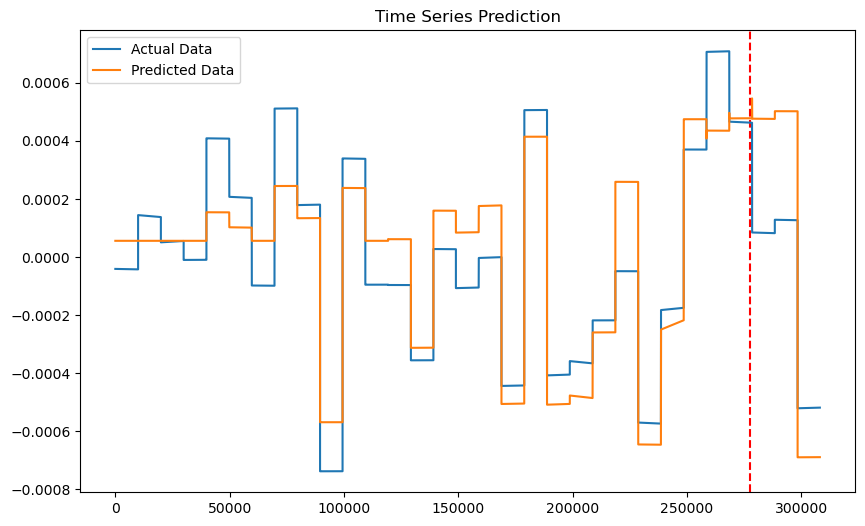

In [31]:
df_X_ss = ss.transform(df.drop(columns=['File'])) # old transformers 
df_y_mm = mm.transform(df["Clock Bias (seconds)"].values.reshape(-1,1)) # older transformers

#split sequences 
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, historical_window, forward_window)

# convert tensors 
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

#reshape dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], historical_window, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)

true, preds = [], []

for i in range(len(dataY_plot)): 
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)): 
    preds.append(data_predict[i][0])

plt.figure(figsize=(10,6))
test_cutoff = round(0.90 * total_samples)
plt.axvline(x=test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi = 300)
plt.show()

In [32]:
r2 = r2_score(true, preds)
r2

0.7483021665802276

In [33]:
mean_absolute_percentage_error(true, preds)

6.383119725205217

In [34]:
root_mean_squared_error(true, preds)

0.00017209666874642274

Although these results may seem good, it's not actually as good as it appears. This plot above, where the test data is any time step beyond the red-dashed line, seems to suggest that our moel is amazingly accurate at predicting the price of Bitcoin, a few months into the future. However, what's happening here is a form of data leakage, where information about the test targets has leaked into the test features. That is, whenever we run the model, it has access to the <code>Open</code> price for that day, which is obviously going to be extremely close to the price Bitcoin endsup at for the particular time step. When we loop over our predictions on the model, we append the first predicted value for that time-step. This means that every prediction we are plotting on here has the benefit of being the next predicted value - and not the sequence of 50 values into the future (as we set up in our problem definition). 


If we really want to see how our model is performing, we have to feed it the 100 time-steps of features before the final value in the test set and then use one model forward pass to calculate the 50 time-step prices in the test set. 

Recall from above that double-checked our test features in the final batch sample in the test set werre the 100 time steps up to the time-step we're attempting to predict. That is, we feed the model 100 days of information upt to 26th Nov 2021, and get it to predict 50 days of Bitcoin prices, from this day to the 14th Jan 2022. 

In [35]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # obtains the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

In [36]:
test_target = y_test_tensors[-1].detach().numpy()
test_target = mm.inverse_transform(test_target.reshape(1,-1))
test_target = test_target[0].tolist()

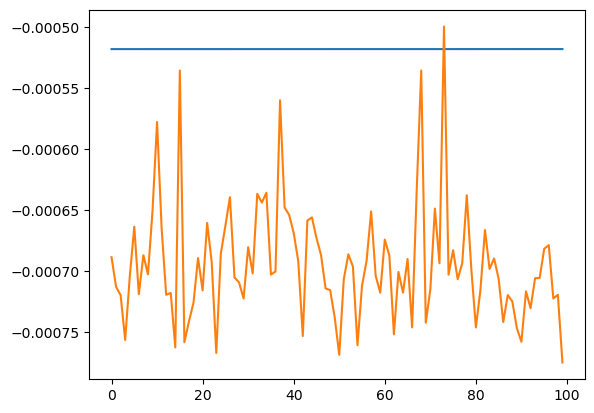

In [37]:
plt.plot(test_target, label = "Actual Data")
plt.plot(test_predict, label = "LSTM Predictions")
plt.savefig("small_plot.png", dpi = 300)
plt.show();

This is good. If we feed the last 100 days of information, our model successfully predicts a steady decline in the price of Bitcoin over the next 50 days. For one last plot, let's put this in perspective of the scale of the data. 

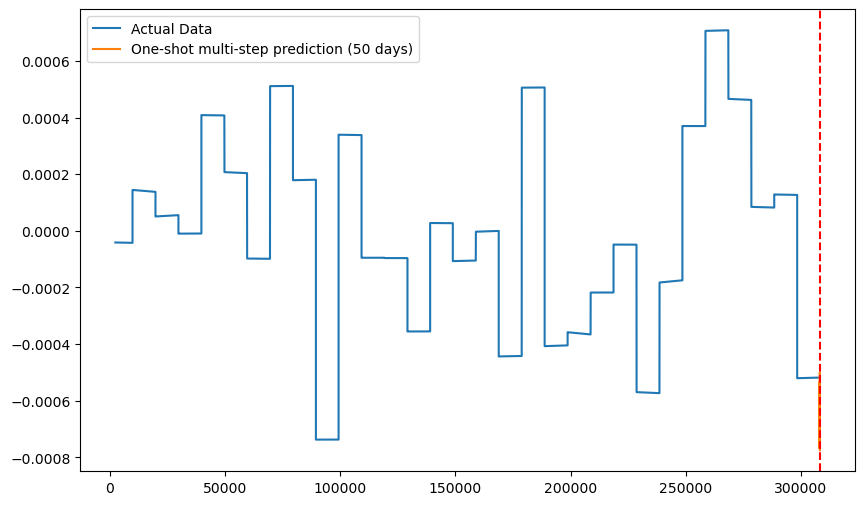

In [38]:
plt.figure(figsize=(10,6))
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label="Actual Data"); 
c = [x for x in range (len(y)-forward_window, len(y))]
plt.plot(c, test_predict, label = "One-shot multi-step prediction (50 days)")
plt.axvline(x=len(y)-forward_window, c='r', linestyle="--")
plt.legend()
plt.show()

So, if we'd run our model on 26 Nov 2021, we would have been correct in selling off our Bitcoin. The model correctly predicts a price drop, as well as the rate at which it drops. 

This orange whole curve is generated without looking at ANY target data. Yes, to be fair, the model is very familiar with all the actual targets before the dashed red line. However, once we move past the training set into the test set the model has no idea what the test targets are. It has to generate its prediction  from the input feature only. 

# Conclusion

In [39]:
r2 = r2_score(test_target, test_predict)
r2

-708084222.9577161

In [40]:
test_target

[-0.000518314482178539,
 -0.0005183142493478954,
 -0.0005183140165172517,
 -0.0005183137836866081,
 -0.0005183134926483035,
 -0.0005183132598176599,
 -0.0005183130269870162,
 -0.0005183127941563725,
 -0.0005183125613257289,
 -0.0005183123284950852,
 -0.0005183120956644416,
 -0.0005183118628337979,
 -0.0005183116300031543,
 -0.0005183113971725106,
 -0.0005183111061342061,
 -0.0005183109315112233,
 -0.0005183106404729187,
 -0.000518310465849936,
 -0.0005183101748116314,
 -0.0005183099419809878,
 -0.0005183097091503441,
 -0.0005183094763197005,
 -0.0005183092434890568,
 -0.0005183090106584132,
 -0.0005183087778277695,
 -0.0005183085449971259,
 -0.0005183083121664822,
 -0.0005183080793358386,
 -0.000518307788297534,
 -0.0005183076136745512,
 -0.0005183073226362467,
 -0.0005183071480132639,
 -0.0005183068569749594,
 -0.0005183066241443157,
 -0.0005183063913136721,
 -0.0005183061584830284,
 -0.0005183059256523848,
 -0.0005183056928217411,
 -0.0005183054599910975,
 -0.0005183052271604538,
 -0

In [41]:
test_predict

[-0.0006888150237500668,
 -0.0007131047314032912,
 -0.000719993025995791,
 -0.0007566733984276652,
 -0.0007050555432215333,
 -0.0006638069171458483,
 -0.0007191275362856686,
 -0.0006871717050671577,
 -0.0007028397521935403,
 -0.0006511464016512036,
 -0.0005780264618806541,
 -0.0006651131552644074,
 -0.0007196328951977193,
 -0.000718141789548099,
 -0.000762766576372087,
 -0.0005358465132303536,
 -0.00075852609006688,
 -0.0007414156571030617,
 -0.0007260912097990513,
 -0.0006895079859532416,
 -0.0007160641252994537,
 -0.0006607312825508416,
 -0.0006929344963282347,
 -0.000767295656260103,
 -0.0006859131972305477,
 -0.0006630554562434554,
 -0.0006397182587534189,
 -0.0007054322632029653,
 -0.0007094454485923052,
 -0.000722705852240324,
 -0.0006806721212342381,
 -0.0007021274650469422,
 -0.0006368991453200579,
 -0.0006441095611080527,
 -0.0006360181723721325,
 -0.0007030910928733647,
 -0.0007005123770795763,
 -0.0005602289456874132,
 -0.000648113782517612,
 -0.0006541762268170714,
 -0.0006

In [42]:

root_mean_squared_error(test_target, test_predict)

0.00018230703136753649